In [1]:
import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# 读取原始网络数据
df = pd.read_csv(r'block_ppi_GAPR.txt', sep='\t')
G_original = nx.from_pandas_edgelist(df, '#Protein A', 'Protein B')

# 计算原始网络的割点
original_APs = set(nx.articulation_points(G_original))
original_nodes = set(G_original.nodes())
num_original_APs = len(original_APs)

# 定义要测试的移除比例，从1%到50%
percentages = np.arange(1, 51)  # 1% 到 50%

# 定义重复次数
num_repetitions = 50

# 存储所有实验结果的列表
all_results = []

# 使用 tqdm 显示进度条
for pct in tqdm(percentages, desc='Processing percentages'):
    # 计算需要移除的节点数量
    num_nodes_to_remove = int(len(G_original) * pct / 100)
    num_nodes_to_remove = max(num_nodes_to_remove, 1)  # 确保至少移除一个节点

    # 用于累积结果的列表
    temp_proportions_of_APs_remaining = []
    temp_proportions_of_APs_still_APs = []

    for rep in range(1, num_repetitions + 1):
        # 随机选择要移除的节点
        nodes_to_remove = random.sample(original_nodes, num_nodes_to_remove)

        # 创建网络副本并移除节点
        G_removed = G_original.copy()
        G_removed.remove_nodes_from(nodes_to_remove)

        # 更新剩余的原始割点（那些未被移除的割点）
        remaining_original_APs = original_APs - set(nodes_to_remove)
        num_remaining_original_APs = len(remaining_original_APs)

        if num_remaining_original_APs == 0:
            # 如果所有原始割点都被移除了
            proportion_APs_remaining = 0
            proportion_APs_still_APs = 0
        else:
            # 计算移除节点后的新割点
            try:
                new_APs = set(nx.articulation_points(G_removed))
            except nx.NetworkXError:
                # 如果图为空或没有节点，跳过本次循环
                proportion_APs_remaining = 0
                proportion_APs_still_APs = 0
                continue

            # 计算剩余的原始割点中仍然是割点的比例
            num_APs_still_APs = len(remaining_original_APs & new_APs)
            proportion_APs_remaining = num_remaining_original_APs / num_original_APs
            proportion_APs_still_APs = num_APs_still_APs / num_remaining_original_APs if num_remaining_original_APs > 0 else 0

        # 保存本次实验的结果
        temp_proportions_of_APs_remaining.append(proportion_APs_remaining)
        temp_proportions_of_APs_still_APs.append(proportion_APs_still_APs)

        # 将每次循环的结果添加到总结果列表中
        all_results.append({
            'Percentage of Nodes Removed (%)': pct,
            'Repetition': rep,
            'Proportion of Original APs Remaining': proportion_APs_remaining,
            'Proportion of Remaining APs Still APs': proportion_APs_still_APs
        })

# 将所有实验结果转换为DataFrame
df_all_results = pd.DataFrame(all_results)

# 分别计算每个移除比例下的平均值和标准差
grouped = df_all_results.groupby('Percentage of Nodes Removed (%)')
mean_APs_remaining = grouped['Proportion of Original APs Remaining'].mean()
std_APs_remaining = grouped['Proportion of Original APs Remaining'].std()
mean_APs_still_APs = grouped['Proportion of Remaining APs Still APs'].mean()
std_APs_still_APs = grouped['Proportion of Remaining APs Still APs'].std()

# 准备绘图数据
x = percentages
meany_remaining = mean_APs_remaining.values
err_remaining = std_APs_remaining.values
meany_still_APs = mean_APs_still_APs.values
err_still_APs = std_APs_still_APs.values


# 保存所有实验结果到Excel文件
df_all_results.to_excel(r'D:\metabolic network\转录组\Wgcna\all_iterations_results.xlsx', index=False)

# 分别保存平均结果和标准差到Excel文件
df_stats = pd.DataFrame({
    'Percentage of Nodes Removed (%)': x,
    'Mean Proportion of Original APs Remaining': meany_remaining,
    'Std Proportion of Original APs Remaining': err_remaining,
    'Mean Proportion of Remaining APs Still APs': meany_still_APs,
    'Std Proportion of Remaining APs Still APs': err_still_APs
})
df_stats.to_excel(r'D:\metabolic network\转录组\Wgcna\average_and_std_results.xlsx', index=False)


Processing percentages:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\11340\AppData\Local\Temp\ipykernel_17460\1219963083.py:38: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  nodes_to_remove = random.sample(original_nodes, num_nodes_to_remove)
Processing percentages: 100%|██████████| 50/50 [01:19<00:00,  1.59s/it]


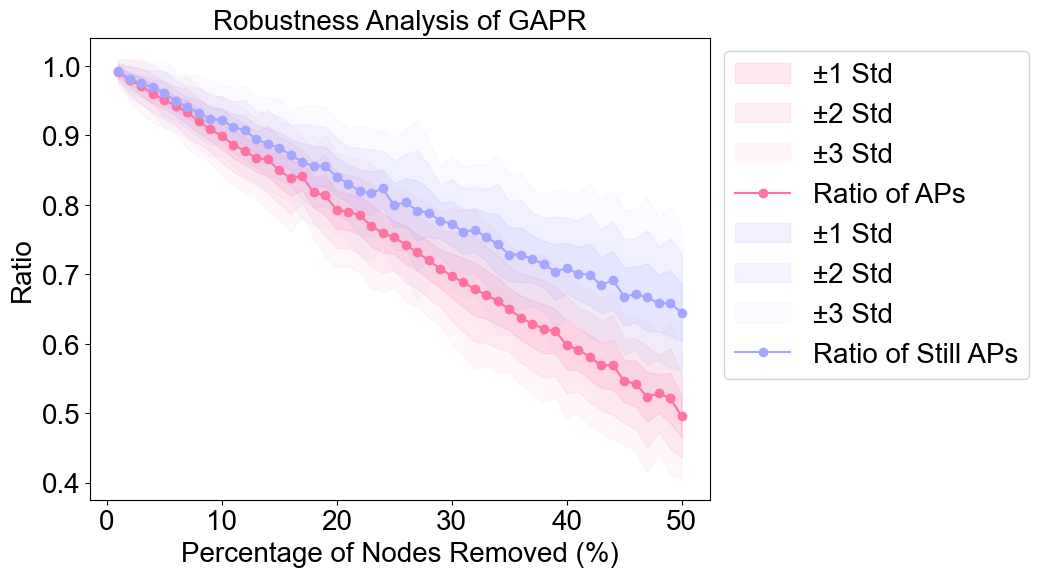

In [18]:
plt.figure(figsize=(8, 6))

# 绘制“Proportion of Original APs Remaining”的标准差区域
plt.fill_between(x, meany_remaining - err_remaining, meany_remaining + err_remaining, color='#ff72a1', alpha=0.15, label='±1 Std')
plt.fill_between(x, meany_remaining - 2 * err_remaining, meany_remaining + 2 * err_remaining, color='#ff72a1', alpha=0.1, label='±2 Std')
plt.fill_between(x, meany_remaining - 3 * err_remaining, meany_remaining + 3 * err_remaining, color='#ff72a1', alpha=0.05, label='±3 Std')

# 绘制平均值曲线
plt.plot(x, meany_remaining, 'o-', color='#ff72a1', label='Ratio of APs')
# 填充标准差区域
plt.fill_between(x, meany_still_APs - err_still_APs, meany_still_APs + err_still_APs, color='#a5a6ff', alpha=0.15, label='±1 Std')
plt.fill_between(x, meany_still_APs - 2 * err_still_APs, meany_still_APs + 2 * err_still_APs, color='#a5a6ff', alpha=0.1, label='±2 Std')
plt.fill_between(x, meany_still_APs - 3 * err_still_APs, meany_still_APs + 3 * err_still_APs, color='#a5a6ff', alpha=0.05, label='±3 Std')

# 绘制平均值曲线
plt.plot(x, meany_still_APs, 'o-', color='#a5a6ff', label='Ratio of Still APs')
# 配置图形属性
plt.xlabel('Percentage of Nodes Removed (%)', fontname='Arial', fontsize=20)
plt.ylabel('Ratio', fontname='Arial', fontsize=20)
plt.title('Robustness Analysis of GAPR', fontname='Arial', fontsize=20)

# 设置坐标轴刻度字体为 Arial 并增大字号
plt.xticks(fontname='Arial', fontsize=20)
plt.yticks(fontname='Arial', fontsize=20)
plt.legend( fontsize=20, loc='upper left', bbox_to_anchor=(1, 1),prop={'family': 'Arial', 'size': 20})
plt.grid(False)
#
plt.savefig(r'Network_Robustness_Analysis_GAPR_new.svg', dpi=300)


Finder-Robutness

In [7]:
import pandas as pd

In [19]:
Finder_results=pd.read_csv(r'D:\文章\RORgt\robustness_FINDER_block_10.csv')

In [20]:
Finder_results

,ratio,sol_nodes_num,sol_nodes_ratio_origin,sol_nodes_ratio,remain_ratio_origin,remain_ratio
0,0.01,1050,0.873544,0.981510,0.873544,0.981510
1,0.01,1058,0.880200,0.988988,0.880200,0.988988
2,0.01,1039,0.864393,0.971228,0.865112,0.972036
3,0.01,1021,0.849418,0.954402,0.850125,0.955197
4,0.01,1039,0.864393,0.971228,0.864393,0.971228
...,...,...,...,...,...,...
2495,0.50,823,0.684692,0.769317,0.699830,0.786326
2496,0.50,798,0.663894,0.745948,0.690311,0.775631
2497,0.50,807,0.671381,0.754361,0.692704,0.778319
2498,0.50,785,0.653078,0.733796,0.672665,0.755803


In [21]:
grouped = Finder_results.groupby('ratio')
mean_APs_remaining = grouped['sol_nodes_ratio'].mean()
std_APs_remaining = grouped['sol_nodes_ratio'].std()
mean_APs_still_APs = grouped['remain_ratio'].mean()
std_APs_still_APs = grouped['remain_ratio'].std()

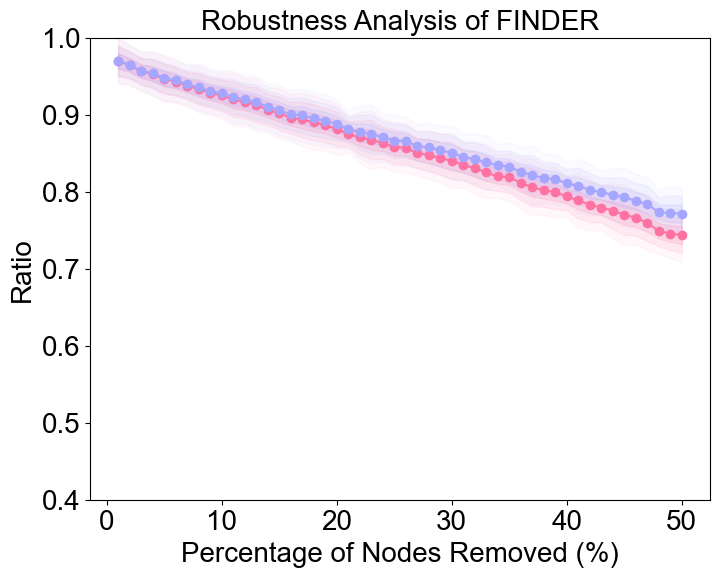

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick
percentages = np.arange(1, 51) 
x = percentages
meany_remaining = mean_APs_remaining.values
err_remaining = std_APs_remaining.values
meany_still_APs = mean_APs_still_APs.values
err_still_APs = std_APs_still_APs.values
plt.figure(figsize=(8, 6))

# 绘制“Proportion of Original APs Remaining”的标准差区域
plt.fill_between(x, meany_remaining - err_remaining, meany_remaining + err_remaining, color='#ff72a1', alpha=0.15, label='±1 Std Dev')
plt.fill_between(x, meany_remaining - 2 * err_remaining, meany_remaining + 2 * err_remaining, color='#ff72a1', alpha=0.1, label='±2 Std Dev')
plt.fill_between(x, meany_remaining - 3 * err_remaining, meany_remaining + 3 * err_remaining, color='#ff72a1', alpha=0.05, label='±3 Std Dev')

# 绘制平均值曲线
plt.plot(x, meany_remaining, 'o-', color='#ff72a1', label='Mean Proportion of Original APs Remaining')
# 填充标准差区域
plt.fill_between(x, meany_still_APs - err_still_APs, meany_still_APs + err_still_APs, color='#a5a6ff', alpha=0.15, label='±1 Std Dev')
plt.fill_between(x, meany_still_APs - 2 * err_still_APs, meany_still_APs + 2 * err_still_APs, color='#a5a6ff', alpha=0.1, label='±2 Std Dev')
plt.fill_between(x, meany_still_APs - 3 * err_still_APs, meany_still_APs + 3 * err_still_APs, color='#a5a6ff', alpha=0.05, label='±3 Std Dev')

# 绘制平均值曲线
plt.plot(x, meany_still_APs, 'o-', color='#a5a6ff', label='Mean Proportion of Remaining key nodes Still nodes')
plt.ylim(0.4, 1.0)
# 配置图形属性
plt.xlabel('Percentage of Nodes Removed (%)', fontname='Arial', fontsize=20)
plt.ylabel('Ratio', fontname='Arial', fontsize=20)
plt.title('Robustness Analysis of FINDER', fontname='Arial', fontsize=20)

# 设置坐标轴刻度字体为 Arial 并增大字号
plt.xticks(fontname='Arial', fontsize=20)
plt.yticks(fontname='Arial', fontsize=20)
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
plt.grid(False)

plt.savefig(r'Network_Robustness_Analysis_FINDER_new.svg', dpi=300)
